# Modeling Coronal Loops in 3D with `sunpy.coordinates`

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
from scipy.ndimage import gaussian_filter
import scipy.integrate
import scipy.optimize
import matplotlib.pyplot as plt
import matplotlib.colors
import astropy.units as u
import astropy.time
import astropy.constants as const
from astropy.coordinates import SkyCoord
from sunpy.map import GenericMap
from sunpy.util.metadata import MetaDict
from sunpy.sun import constants as sun_const
from sunpy.coordinates import Helioprojective,HeliographicStonyhurst,Heliocentric

%matplotlib inline

[Coronal loops](https://en.wikipedia.org/wiki/Coronal_loop) are the building blocks of the solar corona, the outermost layer of the Sun's atmosphere. Because the pressure exerted by the coronal magnetic field is much stronger than the pressure of the surrounding gas, hot plasma is forced to flow along the magnetic field lines, creating bright arches, or *loops*, that extend high above the solar surface. As a result, the corona is often modeled as an ensemble of one-dimensional loop structures rather than a three-dimensional box of magnetized plasma. This allows for detailed simulations over massive spatial scales that are not accessible by 3D MHD simulations due to their massive computational cost. [This review paper](http://adsabs.harvard.edu/abs/2010LRSP....7....5R) provides an excellent overview of both the observational and modeling sides of coronal loop physics.

The `sunpy.coordinates` module is a useful tool for expressing locations on the Sun in various coordinate systems. While most often used in the context of analyzing and manipulating observational data, we can also use this module to build three-dimensional models of loops in the corona.

## Getting the Coordinates of a Single Loop

Let's consider a semi-circular loop with both footpoints rooted on the surface of the Sun with a length $L=500$ Mm and centered at a latitude of $\Theta=30^{\circ}$. We have to do a bit of algebra to find these coordinates, but all we are doing is expressing them in terms of spherical Heliographic Stonyhurst coordinate system, $(r,\Theta,\Phi)$. For a comprehensive overivew of solar coordinate systems, see [Thompson (2006)](http://adsabs.harvard.edu/abs/2006A%26A...449..791T).

In [2]:
def semi_circular_loop(length,theta0=0*u.deg,n=1000):
    r_1 = const.R_sun
    def r_2_func(x):
        return np.arccos(0.5*x/r_1.to(u.cm).value) - np.pi + length.to(u.cm).value/2./x
    r_2 = scipy.optimize.bisect(r_2_func,length.to(u.cm).value/(2*np.pi),
                               length.to(u.cm).value/np.pi) * u.cm
    alpha = np.arccos(0.5*(r_2/r_1).decompose())
    phi = np.linspace(-np.pi*u.rad + alpha,np.pi*u.radian-alpha,n)
    # Quadratic formula to find r
    a = 1.
    b = -2*(r_1.to(u.cm)*np.cos(phi.to(u.radian)))
    c = r_1.to(u.cm)**2 - r_2.to(u.cm)**2
    r = (-b + np.sqrt(b**2 - 4*a*c))/2/a 
    # Choose only points above the surface
    i_r = np.where(r>r_1)
    r = r[i_r]
    phi = phi[i_r]
    hcc_frame = Heliocentric(observer=SkyCoord(
        lon=0*u.deg,lat=theta0,radius=r_1,frame='heliographic_stonyhurst'))
    return (SkyCoord(x=r.to(u.cm)*np.sin(phi.to(u.radian)),
                     y=u.Quantity(r.shape[0]*[0*u.cm]),
                     z=r.to(u.cm)*np.cos(phi.to(u.radian)),
                     frame=hcc_frame)
            .transform_to('heliographic_stonyhurst'))

In [3]:
loop = semi_circular_loop(500*u.Mm,n=1000,theta0=30*u.deg)

In [4]:
loop[[0,-1]] # First and last points

<SkyCoord (HeliographicStonyhurst: obstime=None): (lon, lat, radius) in (deg, deg, km)
    [(-14.04362534, 29.25292568, 702309.92444939),
     ( 14.04362534, 29.25292568, 702309.92444939)]>

Note that this function returns an Astropy `SkyCoord` object. You can read more about these in the [Astropy docs](http://docs.astropy.org/en/stable/coordinates/index.html). Simply put, a `SkyCoord` object allows us to specify a coordinate-aware set of points in the sky, specifically on the Sun. SunPy provides many of the commonly used solar coordinate systems to be used by `SkyCoord`. You can read more about them [here](http://docs.sunpy.org/en/v0.9.0/code_ref/coordinates.html).

To plot our loop, we need to construct a dummy `sunpy.map.Map` object. This just provides a projected coordinate system so that we can plot our loop in two dimensions.

In [5]:
data = np.ones((10,10))
time_now = astropy.time.Time.now()
meta = MetaDict({
    'ctype1': 'HPLN-TAN','ctype2': 'HPLT-TAN',
    'cunit1': 'arcsec', 'cunit2': 'arcsec',
    'crpix1': (data.shape[0] + 1)/2., 'crpix2': (data.shape[1] + 1)/2.,
    'cdelt1': 1.0, 'cdelt2': 1.0, 'crval1': 0.0, 'crval2': 0.0,
    'hgln_obs': 0.0,
    'hglt_obs': 0.0,
    'dsun_obs': const.au.to(u.m).value,
    'dsun_ref': const.au.to(u.m).value,
    'rsun_ref': const.R_sun.to(u.m).value,
    'rsun_obs': ((const.R_sun / const.au).decompose() 
                 * u.radian).to(u.arcsec).value,
    't_obs': time_now.iso,
    'date-obs': time_now.iso,
})
dummy_map = GenericMap(data,meta)

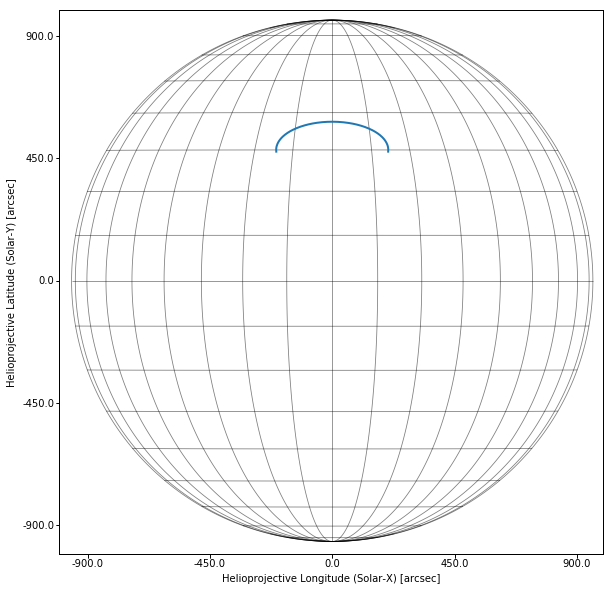

In [6]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=dummy_map)
dummy_map.plot(alpha=0,extent=[-1000,1000,-1000,1000],title=False)
ax.plot_coord(loop.transform_to(dummy_map.coordinate_frame),color='C0',lw=2)
dummy_map.draw_grid(grid_spacing=10*u.deg,color='k',axes=ax)

## Computing the Density and Emission Measure

We want to model the thermodynamics of our loop in the field-aligned direction. In hydrostatic equilibrium, the pressure balance in a loop can be written as,

$$
\frac{dP}{dr} = -m_in g_{\odot}\left(\frac{R_{\odot}}{r}\right)^2
$$

where $g_{\odot}$ and $R_{\odot}$ are the surface gravity and radius of the Sun, respectively, $n$ is the density, and $m_i$ is the ion mass. We want to find the density as a function of $s$, the coordinate along the loop. We can rewrite the above equation in terms of $s$,

$$
\frac{dP}{ds} = \frac{dP}{dr}\frac{dr}{ds} = -m_in g_{\odot}\left(\frac{R_{\odot}}{r(s)}\right)^2\frac{dr}{ds}
$$

Using the ideal gas law ($P=2k_BnT$) and assuming an isothermal loop, we can integrate both sides and find an expression for the density $n$ as a function of the field-aligned coordinate $s$,

$$
n(s) = n_0\exp\left[-\frac{R_{\odot}^2}{\lambda_P}\int_0^s\mathrm{d}s^{\prime}\frac{dr/ds^{\prime}}{r^2(s^{\prime})}\right]
$$

where $\lambda_P=2k_BT/m_ig_{\odot}$ is the pressure scale height and $n_0$ is the density at $s=0$, i.e. at the footpoint. This gives us the number density at each point along our loop. Let's write a function to compute the density for a given $L$, $n_0$, and temperature $T$.

In [7]:
def isothermal_density(loop, length, n0=1e12*u.cm**(-3), T=1*u.MK):
    s = np.linspace(0*length.unit,length,loop.radius.shape[0]).to(u.cm)
    r = loop.radius.to(u.cm)
    lambda_p = 2*const.k_B*T/(const.m_p*sun_const.surface_gravity)
    integrand = np.gradient(r.to(u.cm).value,s.to(u.cm).value) / (r.to(u.cm)**2)
    integral = np.array([scipy.integrate.simps(integrand[:(i+1)].value, s[:(i+1)].value)
                         for i in range(s.shape[0])])/u.cm
    exp_term = ((const.R_sun**2)/lambda_p).to(u.cm)*integral
    return n0*np.exp(-exp_term)

We can then evaluate the the density along the loop that we created above, using a footpoint density of $n_0=10^{11}$ cm$^{-3}$ and temperature $T=10^6$ K.

In [8]:
density = isothermal_density(loop,500*u.Mm,T=1*u.MK,n0=1e11/(u.cm**3))

A commonly studied quantity in coronal loop physics is the emission measure distribution,

$$
\mathrm{EM} = \int_{LOS}\mathrm{d}h\,n^2
$$

Notice that this quantity is computed by integrating along the line of sight from the observer to the feature on the Sun. That means we need both the density (which we computed above) as well the location of the loop with respect to some observer. 

## Projecting and Binning 

Now that we have the loop coordinates and the density along the loop, we need to project the loop on the plane of the sky and integrate along the line of sight.

First, let's choose an observing location. We can use the exact same `SkyCoord` object that we used to express our loop coordinates! We'll place our observer at $(1\,\mathrm{AU},0^{\circ},0^{\circ})$, i.e. pointing right at the center of the sun at a distance of 1 AU.

In [9]:
observer = SkyCoord(lon=-0*u.deg,
                    lat=0*u.deg,
                    radius=const.au,
                    frame='heliographic_stonyhurst')

Next, we convert the loop to a Helioprojective coordinate system as defined by our observer.

In [10]:
coords = loop.transform_to(Helioprojective(observer=observer))

To compute the line-of-sight emission measure, we'll use a two-dimensional histogram and bin the $(\theta_x,\theta_y)$ coordinates, using $n^2\Delta h$ as the weights. First, we need to set up the bins for our histogram.

In [11]:
res_x,res_y = 5*u.arcsec/u.pixel,5*u.arcsec/u.pixel
pad_x,pad_y = res_x*5*u.pixel,res_y*5*u.pixel
min_x,max_x = coords.Tx.min()-pad_x,coords.Tx.max()+pad_x
min_y,max_y = coords.Ty.min()-pad_y,coords.Ty.max()+pad_y
min_z,max_z = coords.distance.min(),coords.distance.max()
bins_x = np.ceil((max_x - min_x) / res_x)
bins_y = np.ceil((max_y - min_y) / res_y)
bins_z = max(bins_x, bins_y)

Next, we can compute the weights.

In [12]:
dz = (max_z - min_z).cgs / bins_z * (1. * u.pixel)
em = density**2 * dz.value

We'll exploit our helioprojective coordinate system to figure out what coordinates are blocked by the solar disk and mask those that are. First we need to figure out the angular size of the solar disk as seen by our observer.

In [13]:
rsun_obs = ((const.R_sun / (observer.radius - const.R_sun))
            .decompose()* u.radian).to(u.arcsec)

Our loop will only be visible if it is in front of the disk or off the limb. Otherwise, we set it to zero visibility.

In [14]:
off_disk = np.sqrt(coords.Tx**2 + coords.Ty**2) > rsun_obs
in_front_of_disk = coords.distance - observer.radius < 0.
mask = np.any(np.stack([off_disk, in_front_of_disk], axis=1), axis=1)

In [15]:
weights = em * mask

We can now use the [histogram2d function in Numpy](https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram2d.html) to bin our loop coordinates, weighted by the visible emission measure distribution, using the appropriate number of bins and ranges.

In [16]:
hist, _, _ = np.histogram2d(
    coords.Tx.value, coords.Ty.value,
    bins=(bins_x.value, bins_y.value),
    range=((min_x.value,max_x.value), (min_y.value,max_y.value)),
    weights=weights)

We'll also apply a Gaussian filter, with widths of 1 pixel in both directions, to simulate the point spread function of an instrument.

In [17]:
em_hist = gaussian_filter(hist.T, (1.0, 1.0))

In order to make this into a `sunpy.map.Map` object, we also need to construct a header based on the observer location and the field of view of our observed loop.

In [18]:
header = MetaDict({
    'crval1': (min_x + (max_x - min_x)/2).value,
    'crval2': (min_y + (max_y - min_y)/2).value,
    'cunit1': coords.Tx.unit.to_string(),
    'cunit2': coords.Ty.unit.to_string(),
    'hglt_obs': observer.lat.to(u.deg).value,
    'hgln_obs': observer.lon.to(u.deg).value,
    'ctype1': 'HPLN-TAN',
    'ctype2': 'HPLT-TAN',
    'dsun_obs': observer.radius.to(u.m).value,
    'rsun_obs': ((const.R_sun / (observer.radius - const.R_sun))
                 .decompose() * u.radian).to(u.arcsec).value,
    'cdelt1': res_x.value,
    'cdelt2': res_y.value,
    'crpix1': (bins_x.value + 1.0)/2.0,
    'crpix2': (bins_y.value + 1.0)/2.0,
})

In [19]:
em_map = GenericMap(em_hist,header)

Finally, let's plot our loop emission measure!

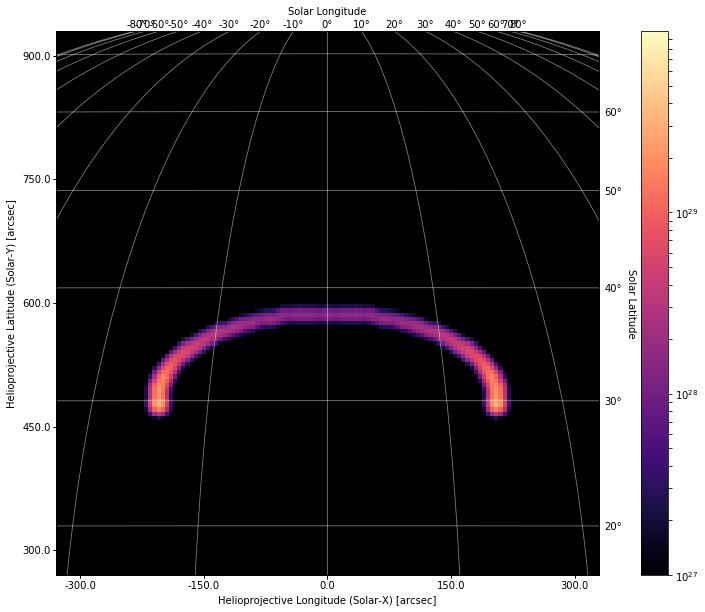

In [20]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection=em_map)
im = em_map.plot(cmap='magma',title=False,
                 norm=matplotlib.colors.SymLogNorm(1,vmin=1e27,vmax=1e30),
                )
ax.plot_coord(SkyCoord(-300*u.arcsec,300*u.arcsec,frame=em_map.coordinate_frame),alpha=0)
ax.plot_coord(SkyCoord(300*u.arcsec,900*u.arcsec,frame=em_map.coordinate_frame),alpha=0)
em_map.draw_grid(grid_spacing=10*u.deg,color='w',axes=ax)
ax.grid(alpha=0)
ax.set_facecolor('k')
fig.colorbar(im,ax=ax)

## Extending to Many Loops
One loop is not all that exciting. Instead, let's model an arcade of loops, choose their lengths from a power-law distribution, and place them over a range of latitudes. We'll write one big function that generates all of our loop coordinates and encapsulates all of the above steps.

In [21]:
def em_arcade(n_loops,observer, length_min=10*u.Mm, length_max=100*u.Mm, theta_min=-10*u.deg,theta_max=10*u.deg):
    # Generate loops
    x = np.random.rand(n_loops)
    alpha = -2.5
    lengths = ((length_max**(alpha + 1.) - length_min**(alpha + 1.))*x 
               + length_min**(alpha + 1.))**(1./(alpha + 1.))
    thetas = np.linspace(theta_min, theta_max, n_loops)
    loops = [semi_circular_loop(l,theta0=th,n=2000) 
             for l,th in zip(lengths,thetas)]
    # Get densities 
    ## Choose heating rate, get T from RTV scaling laws
    E = 1e-3*u.erg/(u.cm**3)/u.s
    T = (1.83e3)*((5.09e4)**(-2/7))*E.value*(lengths.to(u.cm).value)**(2/21) * u.MK
    density = np.hstack([isothermal_density(loop, length, T=t)
                         for loop,length,t in zip(loops,lengths,T)])
    # Stack coordinates and transform
    lon = u.Quantity(np.hstack([l.lon.value for l in loops]),loops[0].lon.unit)
    lat = u.Quantity(np.hstack([l.lat.value for l in loops]),loops[0].lat.unit)
    radius = u.Quantity(np.hstack([l.radius.value for l in loops]),loops[0].radius.unit)
    coords = SkyCoord(lon=lon,lat=lat,radius=radius,frame=loops[0].frame)
    coords = coords.transform_to(Helioprojective(observer=observer))
    # Build histogram
    ## Setup Bins
    res_x,res_y = 5*u.arcsec/u.pixel,5*u.arcsec/u.pixel
    pad_x,pad_y = res_x*5*u.pixel,res_y*5*u.pixel
    min_x,max_x = coords.Tx.min()-pad_x,coords.Tx.max()+pad_x
    min_y,max_y = coords.Ty.min()-pad_y,coords.Ty.max()+pad_y
    min_z,max_z = coords.distance.min(),coords.distance.max()
    bins_x = np.ceil((max_x - min_x) / res_x)
    bins_y = np.ceil((max_y - min_y) / res_y)
    bins_z = max(bins_x, bins_y)
    ## Compute Weights
    dz = (max_z - min_z).cgs / bins_z * (1. * u.pixel)
    em = density**2 * dz.value
    rsun_obs = ((const.R_sun / (observer.radius - const.R_sun))
                .decompose()* u.radian).to(u.arcsec)
    off_disk = np.sqrt(coords.Tx**2 + coords.Ty**2) > rsun_obs
    in_front_of_disk = coords.distance - observer.radius < 0.
    mask = np.any(np.stack([off_disk, in_front_of_disk], axis=1), axis=1)
    weights = em * mask
    # Bin values
    hist, _, _ = np.histogram2d(coords.Tx.value, coords.Ty.value,
                            bins=(bins_x.value, bins_y.value),
                            range=((min_x.value,max_x.value),
                                   (min_y.value,max_y.value)),
                            weights=weights)
    em_hist = gaussian_filter(hist.T, (1.0, 1.0))
    # Make header
    header = MetaDict({
        'crval1': (min_x + (max_x - min_x)/2).value,
        'crval2': (min_y + (max_y - min_y)/2).value,
        'cunit1': coords.Tx.unit.to_string(),
        'cunit2': coords.Ty.unit.to_string(),
        'hglt_obs': observer.lat.to(u.deg).value,
        'hgln_obs': observer.lon.to(u.deg).value,
        'ctype1': 'HPLN-TAN',
        'ctype2': 'HPLT-TAN',
        'dsun_obs': observer.radius.to(u.m).value,
        'rsun_obs': ((const.R_sun / (observer.radius - const.R_sun))
                     .decompose() * u.radian).to(u.arcsec).value,
        'cdelt1': res_x.value,
        'cdelt2': res_y.value,
        'crpix1': (bins_x.value + 1.0)/2.0,
        'crpix2': (bins_y.value + 1.0)/2.0,
    })
    plot_settings = {'cmap': 'magma','title':False,
                     'norm': matplotlib.colors.SymLogNorm(1,vmin=1e30,vmax=1e34)}
    return GenericMap(em_hist,header,plot_settings=plot_settings)

Let's choose a more interesting viewing angle by moving our observer to $(\Phi,\Theta)=(-25^{\circ},-25^{\circ})$

In [22]:
observer = SkyCoord(lon=-25*u.deg,
                    lat=-25*u.deg,
                    radius=const.au,
                    frame='heliographic_stonyhurst')
arcade_map = em_arcade(500,observer,length_min=50*u.Mm,length_max=500*u.Mm,
                       theta_min=-5*u.deg,theta_max=5*u.deg,)

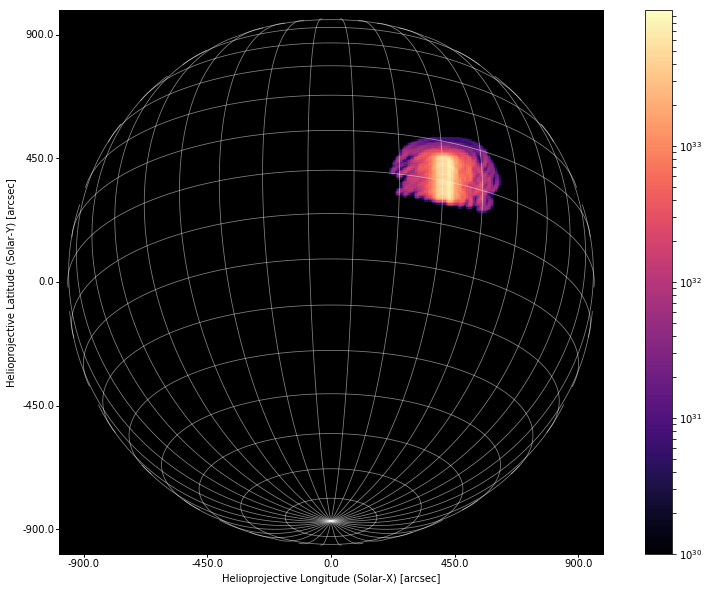

In [23]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection=arcade_map)
im = arcade_map.plot()
arcade_map.draw_grid(grid_spacing=10*u.deg,color='w',axes=ax)
ax.plot_coord(SkyCoord(-900*u.arcsec,-900*u.arcsec,
                       frame=arcade_map.coordinate_frame),color='w',alpha=0)
ax.plot_coord(SkyCoord(900*u.arcsec,900*u.arcsec,
                       frame=arcade_map.coordinate_frame),color='w',alpha=0)
ax.grid(alpha=0)
ax.set_facecolor('k')
fig.colorbar(im,ax=ax)

The power of this approach is that we can change the line of sight that our loops are projected along **just by adjusting the SkyCoord object that represents our observer location**. We don't even need to think about transformation matrices, rotation matrices, etc. SunPy and Astropy provide all of this machinery for us!

Let's move our observer to the south pole such that we are looking through the arcade of loops.

In [24]:
observer = SkyCoord(lon=0*u.deg,
                    lat=-90*u.deg,
                    radius=const.au,
                    frame='heliographic_stonyhurst')
arcade_map = em_arcade(500,observer,length_min=50*u.Mm,length_max=500*u.Mm,
                       theta_min=-5*u.deg,theta_max=5*u.deg,)

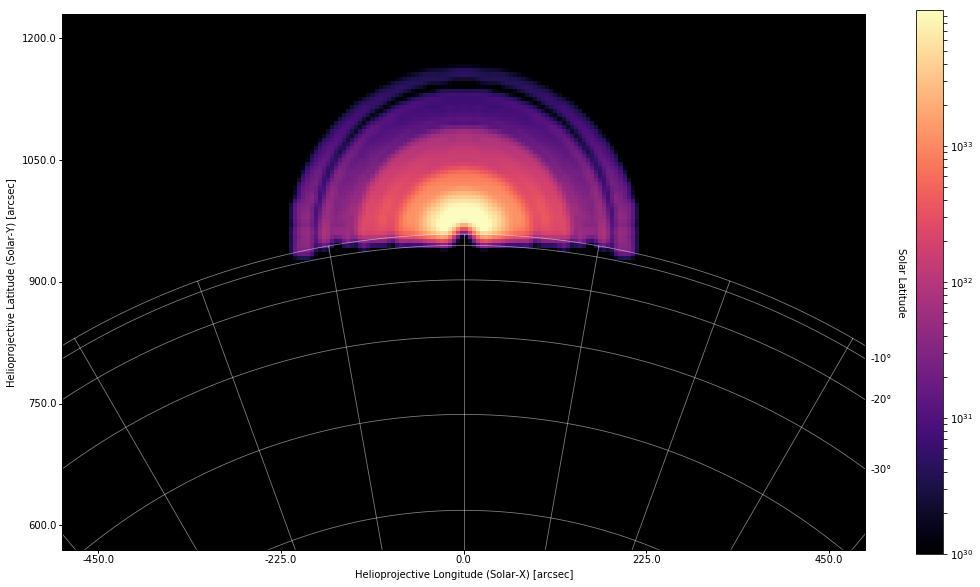

In [25]:
fig = plt.figure(figsize=(18,10))
ax = fig.gca(projection=arcade_map)
im = arcade_map.plot()
arcade_map.draw_grid(grid_spacing=10*u.deg,color='w',axes=ax)
ax.plot_coord(SkyCoord(-450*u.arcsec,600*u.arcsec,
                       frame=arcade_map.coordinate_frame),color='w',alpha=0)
ax.plot_coord(SkyCoord(450*u.arcsec,1200*u.arcsec,
                       frame=arcade_map.coordinate_frame),color='w',alpha=0)
ax.grid(alpha=0)
ax.set_facecolor('k')
fig.colorbar(im,ax=ax)

We can even observe the loops off limb just by setting $\Phi\ge90^{\circ}$. Let's spread the loops out in latitude a bit to make them more visible.

In [26]:
observer = SkyCoord(lon=-100*u.deg,
                    lat=0*u.deg,
                    radius=const.au,
                    frame='heliographic_stonyhurst')
arcade_map = em_arcade(500,observer,length_min=50*u.Mm,length_max=500*u.Mm,
                       theta_min=-15*u.deg,theta_max=15*u.deg,)

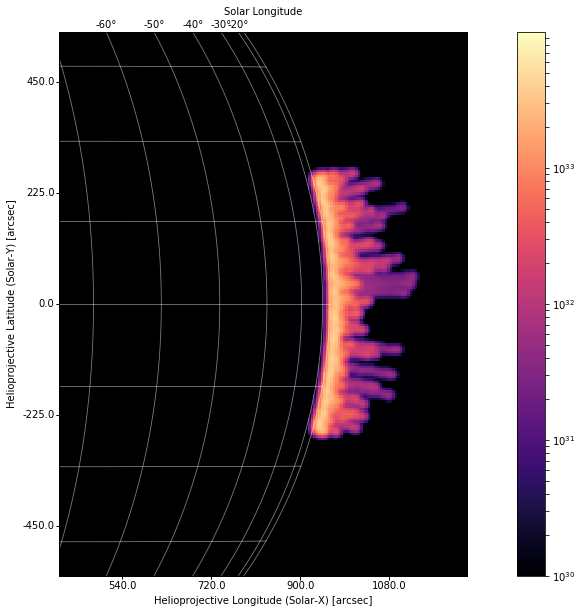

In [27]:
fig = plt.figure(figsize=(18,10))
ax = fig.gca(projection=arcade_map)
im = arcade_map.plot()
arcade_map.draw_grid(grid_spacing=10*u.deg,color='w',axes=ax)
ax.plot_coord(SkyCoord(450*u.arcsec,-500*u.arcsec,
                       frame=arcade_map.coordinate_frame),color='w',alpha=0)
ax.plot_coord(SkyCoord(1200*u.arcsec,500*u.arcsec,
                       frame=arcade_map.coordinate_frame),color='w',alpha=0)
ax.grid(alpha=0)
ax.set_facecolor('k')
fig.colorbar(im,ax=ax)

Notice that because of our viewing angle, the far footpoints are masked by the disk and thus are not visible.